In [1]:
import tensorflow as tf
from tensorflow.contrib import eager as tfe
import numpy as np
from matplotlib import pylab as plt
from sklearn import metrics
from scipy import io as sio

%matplotlib inline

tf.enable_eager_execution()

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
mat = sio.loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X_train = mat.get('X')
X_val = mat.get('Xval')
Y_val = mat.get('yval')

X_train.shape, X_val.shape, Y_val.shape

((307, 2), (307, 2), (307, 1))

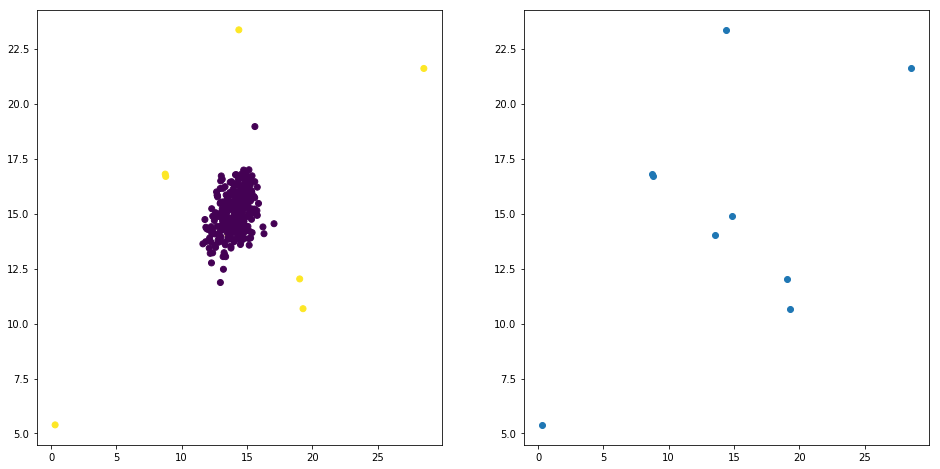

In [4]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X_val[:, 0], X_val[:, 1], c=Y_val[:, 0])
plt.subplot(1, 2, 2)
plt.scatter(X_val[Y_val[:, 0] == 1, 0], X_val[Y_val[:, 0] == 1, 1])

In [5]:
def cal_mean_variance(X):
    mean = tf.reduce_mean(X, axis=0)
    variance = tf.reduce_mean(tf.square(X - mean), axis=0)
    
    return mean, variance

In [6]:
mean, varince = cal_mean_variance(X_train)
mean, varince

(<tf.Tensor: id=2, shape=(2,), dtype=float64, numpy=array([ 14.11222578,  14.99771051])>,
 <tf.Tensor: id=6, shape=(2,), dtype=float64, numpy=array([ 1.83263141,  1.70974533])>)

In [7]:
def cal_density(X, mean, variance):
    part1 = 1 / tf.sqrt(2 * np.pi * variance)
    part2 = tf.exp(-tf.square(X - mean) / (2 * variance))
    result = part1 * part2
    
    return tf.reduce_prod(result, axis=1)

In [8]:
cal_density(X_val[:3], mean, varince)

<tf.Tensor: id=24, shape=(3,), dtype=float64, numpy=array([ 0.04163207,  0.08190901,  0.04071578])>

In [9]:
densities = cal_density(X_val, mean, varince)

In [10]:
def cal_metrics(densities, labels, epsilon):
    predicts = densities < epsilon
    precision = metrics.precision_score(labels, predicts)
    recall = metrics.recall_score(labels, predicts)
    f1 = metrics.f1_score(labels, predicts)
    
    return precision, recall, f1

In [11]:
def search_epsilon(cal_metrics, densities, labels, log_range=(-3, -5)):
    max_f1 = 0
    max_precision = 0
    max_recall = 0
    result_epsilon = 1
    for e in np.logspace(log_range[0], log_range[1], 100):
        precision, recall, f1 = cal_metrics(densities, labels, e)
#         print(e, f1)
        if f1 > max_f1:
            max_f1 = f1
            max_precision = precision
            max_recall = recall
            result_epsilon = e
            
    return result_epsilon, max_f1, max_precision, max_recall

In [12]:
epsilon, f1, precision, recall = search_epsilon(cal_metrics, np.array(densities).reshape(-1, 1), Y_val, log_range=(-3, -5))
print('best')
epsilon, f1, precision, recall

best


(0.00049770235643321089, 0.87500000000000011, 1.0, 0.77777777777777779)

In [13]:
predicts = (densities < epsilon).numpy()
predicts.shape

(307,)

In [14]:
print(metrics.classification_report(Y_val, predicts.reshape(-1, 1)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       298
          1       1.00      0.78      0.88         9

avg / total       0.99      0.99      0.99       307

